<a href="https://colab.research.google.com/github/paulesta55/Traffic-Detection/blob/master/cvaeForTrafficSigns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Variational Autoencoder

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cvae">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/cvae.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
# to generate gifs
!pip install imageio

## Import TensorFlow and other libraries

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import tensorflow_probability as tfp

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

TensorFlow 2.x selected.


In [0]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [0]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

## Use *tf.data* to create batches and shuffle the dataset

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

#GTSRDB Loading

GTSRDB train set unziping

In [0]:
!unzip -q "/content/drive/My Drive/datasets/gtsrdb/GTSRB-Training_fixed.zip" 


GTSRDB test set unziping

In [0]:
!unzip -q "/content/drive/My Drive/datasets/gtsrdb/GTSRB_Final_Test_Images.zip" 

In [0]:
def loadTrain(path="/content/GTSRB/Training"):
  data = []
  for subdir in os.walk(os.path.abspath(path)):
    for im in glob.glob(os.path.join(subdir[0],'*.ppm')):
        data.append(np.array(PIL.Image.open(im).resize((16,16))).astype('float32')) #min size for gtsrdb
  return np.array(data).astype('float32')

def loadTest():
  data = []
  for im in glob.glob(os.path.join('/content/GTSRB/Final_Test/Images','*.ppm')):
    data.append(np.array(PIL.Image.open(im).resize((16,16))).astype('float32')) #min size for gtsrdb
  return np.array(data).astype('float32')

In [0]:
train_images = loadTrain()
train_images = train_images.reshape(train_images.shape[0], 16, 16, 3).astype('float32')
test_images = loadTest()
test_images = test_images.reshape(test_images.shape[0], 16, 16, 3).astype('float32')
train_images /= 255.
test_images /= 255.

BATCH_SIZE = 100
TRAIN_BUF = 26640
TEST_BUF = 12630

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16, 3)


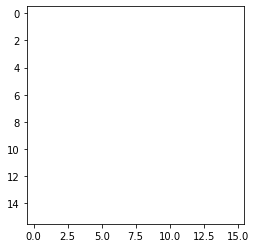

In [0]:
from matplotlib.pyplot import imshow
%matplotlib inline
image = train_set[2]
print(image.shape)
imshow(image)

In [7]:
print(test_images.shape)

(12630, 16, 16, 3)


In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

print(train_dataset) 

<BatchDataset shapes: (None, 16, 16, 3), types: tf.float32>


## Wire up the generative and inference network with *tf.keras.Sequential*

In our VAE example, we use two small ConvNets for the generative and inference network. Since these neural nets are small, we use `tf.keras.Sequential` to simplify our code. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In [0]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(16, 16, 3)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=4*4*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(4, 4, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=3, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    encodes = self.inference_net(x)
    # print("encoding = {0}".format(encodes))
    mean, logvar = tf.split(encodes, num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [0]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  # print('x shape = {}'.format(x))
  mean, logvar = model.encode(x)
  # print("logvar = {}".format(logvar))
  # print("mean = {}".format(mean))
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  # print("logpz = {}".format(logpz))
  logqz_x = log_normal_pdf(z, mean, logvar)
  loss = -tf.reduce_mean(logpx_z + logpz - logqz_x)
  return loss

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

* We start by iterating over the dataset
* During each iteration, we pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* We then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, we pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* **Note:** Since we use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

## Generate Images

* After training, it is time to generate some images
* We start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here we plot the probabilities of Bernoulli distributions


In [0]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(np.asarray(predictions[i, :, :, :]))
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

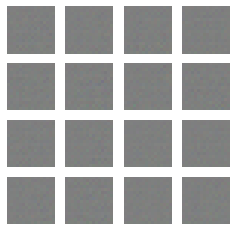

Epoch: 1, Test set ELBO: -445.7168884277344, time elapse for current epoch 16.956501960754395


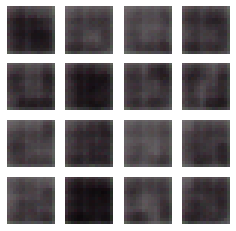

Epoch: 2, Test set ELBO: -433.2984619140625, time elapse for current epoch 15.18697190284729


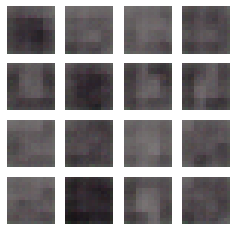

Epoch: 3, Test set ELBO: -428.58953857421875, time elapse for current epoch 16.504831552505493


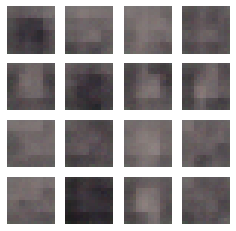

Epoch: 4, Test set ELBO: -420.0052185058594, time elapse for current epoch 15.387587547302246


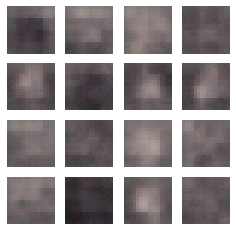

Epoch: 5, Test set ELBO: -415.25030517578125, time elapse for current epoch 15.43006181716919


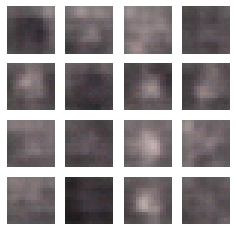

Epoch: 6, Test set ELBO: -412.11871337890625, time elapse for current epoch 15.458348512649536


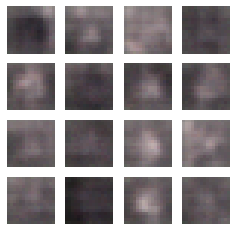

Epoch: 7, Test set ELBO: -410.0646057128906, time elapse for current epoch 15.870598554611206


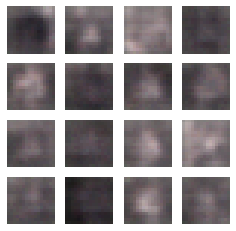

Epoch: 8, Test set ELBO: -408.14544677734375, time elapse for current epoch 18.076114654541016


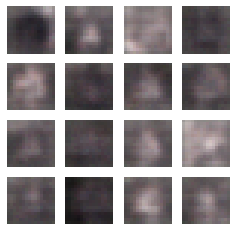

Epoch: 9, Test set ELBO: -406.0101013183594, time elapse for current epoch 15.280231475830078


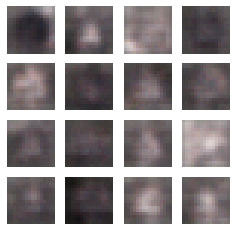

Epoch: 10, Test set ELBO: -404.7351379394531, time elapse for current epoch 15.103023290634155


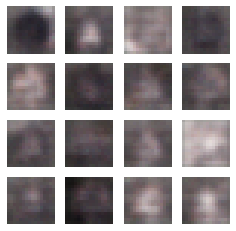

Epoch: 11, Test set ELBO: -403.8143615722656, time elapse for current epoch 17.231324195861816


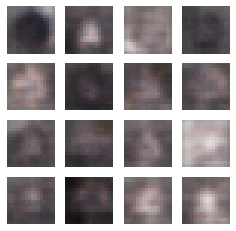

Epoch: 12, Test set ELBO: -402.8272705078125, time elapse for current epoch 16.532784461975098


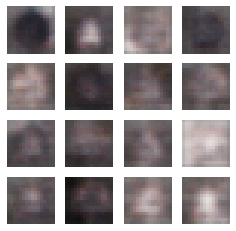

Epoch: 13, Test set ELBO: -401.84271240234375, time elapse for current epoch 15.129996061325073


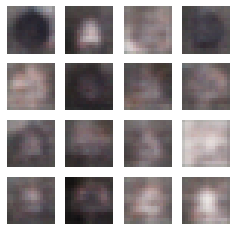

Epoch: 14, Test set ELBO: -401.28814697265625, time elapse for current epoch 15.13444995880127


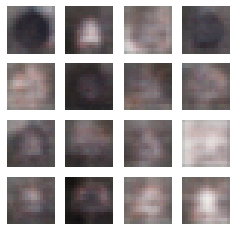

Epoch: 15, Test set ELBO: -400.8096618652344, time elapse for current epoch 15.229795694351196


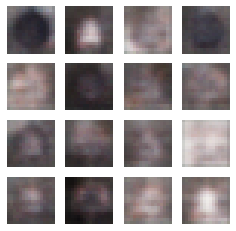

Epoch: 16, Test set ELBO: -400.2307434082031, time elapse for current epoch 15.417924880981445


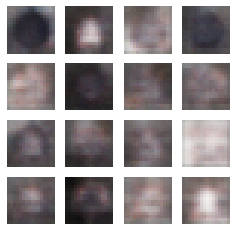

Epoch: 17, Test set ELBO: -400.0882263183594, time elapse for current epoch 15.094134330749512


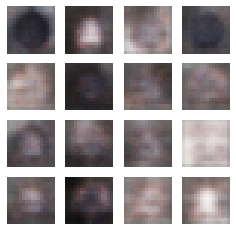

Epoch: 18, Test set ELBO: -399.26678466796875, time elapse for current epoch 15.151034832000732


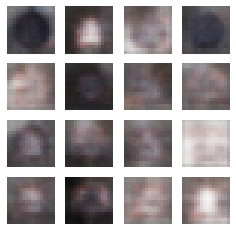

Epoch: 19, Test set ELBO: -398.7377014160156, time elapse for current epoch 15.208042860031128


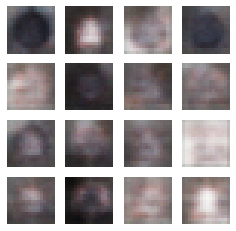

Epoch: 20, Test set ELBO: -398.5062255859375, time elapse for current epoch 15.52037262916565


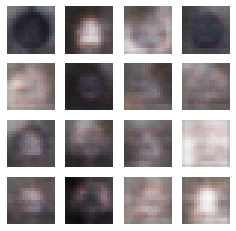

Epoch: 21, Test set ELBO: -398.1284484863281, time elapse for current epoch 15.041614532470703


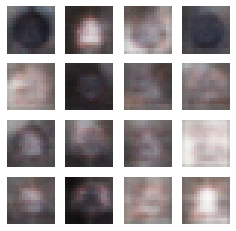

Epoch: 22, Test set ELBO: -398.0363464355469, time elapse for current epoch 15.218078374862671


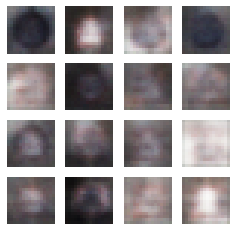

Epoch: 23, Test set ELBO: -397.7857360839844, time elapse for current epoch 15.247145414352417


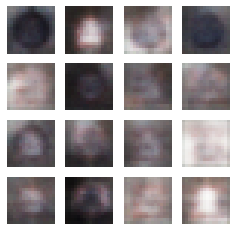

Epoch: 24, Test set ELBO: -397.0789489746094, time elapse for current epoch 15.565401554107666


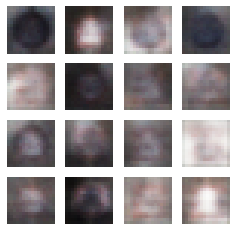

Epoch: 25, Test set ELBO: -397.0928039550781, time elapse for current epoch 15.123364210128784


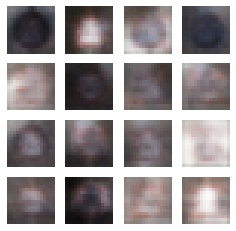

Epoch: 26, Test set ELBO: -396.84686279296875, time elapse for current epoch 15.188388347625732


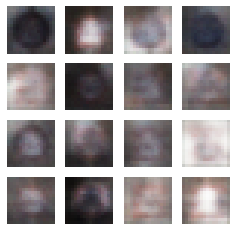

Epoch: 27, Test set ELBO: -396.4565124511719, time elapse for current epoch 15.272778987884521


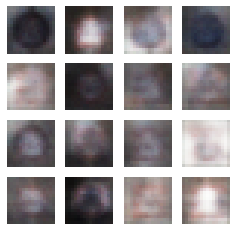

Epoch: 28, Test set ELBO: -396.3533020019531, time elapse for current epoch 15.600908279418945


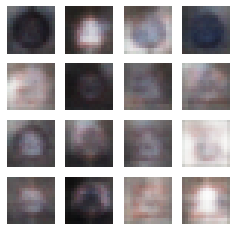

Epoch: 29, Test set ELBO: -395.6529235839844, time elapse for current epoch 15.222563743591309


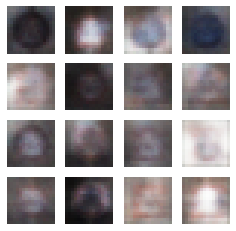

Epoch: 30, Test set ELBO: -395.3327941894531, time elapse for current epoch 15.146678686141968


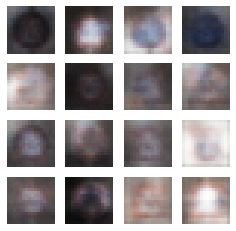

Epoch: 31, Test set ELBO: -395.3223876953125, time elapse for current epoch 15.214282035827637


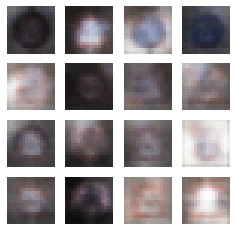

Epoch: 32, Test set ELBO: -394.96600341796875, time elapse for current epoch 15.32848048210144


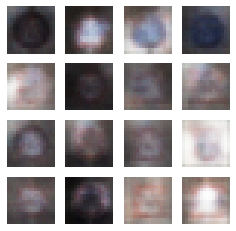

Epoch: 33, Test set ELBO: -394.7236633300781, time elapse for current epoch 15.230080842971802


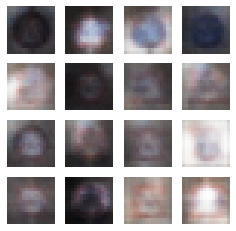

Epoch: 34, Test set ELBO: -394.4421081542969, time elapse for current epoch 15.21247935295105


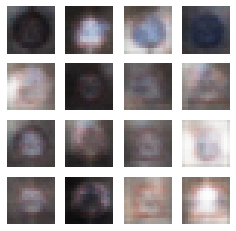

Epoch: 35, Test set ELBO: -394.2643737792969, time elapse for current epoch 15.265910148620605


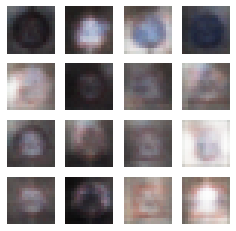

Epoch: 36, Test set ELBO: -394.274658203125, time elapse for current epoch 15.662521600723267


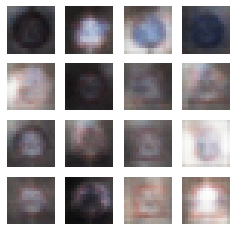

Epoch: 37, Test set ELBO: -393.84228515625, time elapse for current epoch 15.10692286491394


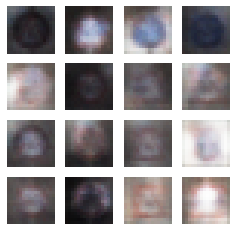

Epoch: 38, Test set ELBO: -394.0360107421875, time elapse for current epoch 15.247251272201538


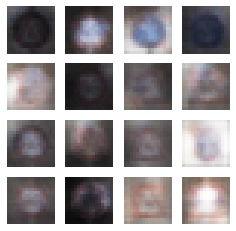

Epoch: 39, Test set ELBO: -394.09259033203125, time elapse for current epoch 15.213478088378906


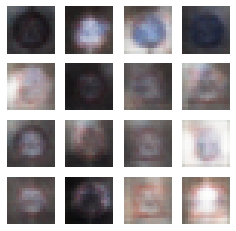

Epoch: 40, Test set ELBO: -393.7595520019531, time elapse for current epoch 16.461440801620483


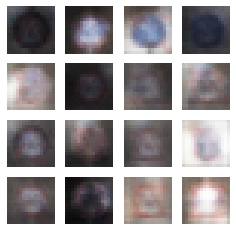

Epoch: 41, Test set ELBO: -393.6394958496094, time elapse for current epoch 15.154184103012085


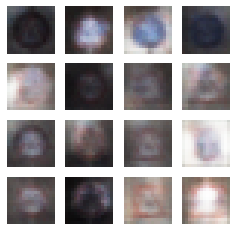

Epoch: 42, Test set ELBO: -393.4830322265625, time elapse for current epoch 15.221988201141357


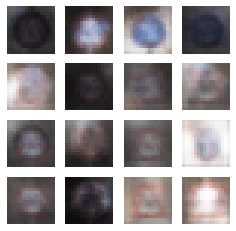

Epoch: 43, Test set ELBO: -393.4753723144531, time elapse for current epoch 15.100887537002563


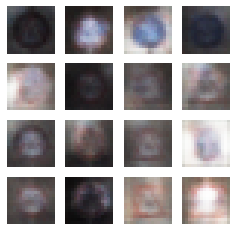

Epoch: 44, Test set ELBO: -393.3828125, time elapse for current epoch 15.532425165176392


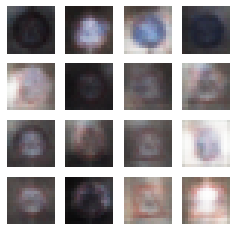

Epoch: 45, Test set ELBO: -393.5185241699219, time elapse for current epoch 15.293425559997559


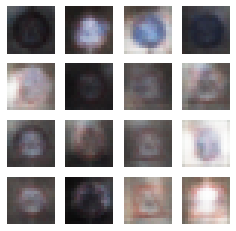

Epoch: 46, Test set ELBO: -393.1651306152344, time elapse for current epoch 15.113212823867798


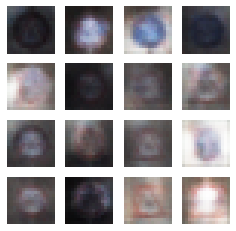

Epoch: 47, Test set ELBO: -393.0335693359375, time elapse for current epoch 15.181099891662598


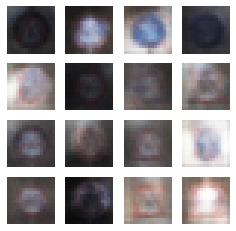

Epoch: 48, Test set ELBO: -392.84918212890625, time elapse for current epoch 15.365376234054565


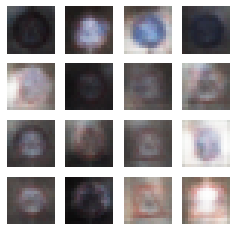

Epoch: 49, Test set ELBO: -392.6142578125, time elapse for current epoch 15.235605001449585


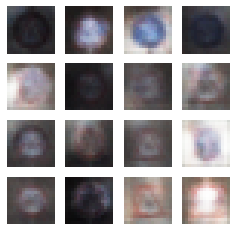

Epoch: 50, Test set ELBO: -392.74285888671875, time elapse for current epoch 15.06947660446167


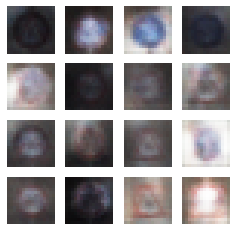

Epoch: 51, Test set ELBO: -392.61468505859375, time elapse for current epoch 14.993641376495361


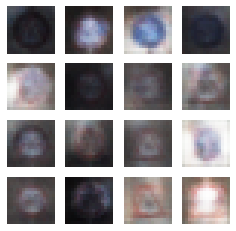

Epoch: 52, Test set ELBO: -392.95648193359375, time elapse for current epoch 15.661133050918579


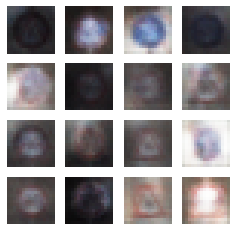

Epoch: 53, Test set ELBO: -392.3244323730469, time elapse for current epoch 15.941315412521362


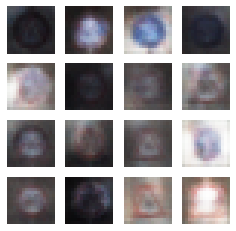

Epoch: 54, Test set ELBO: -392.3410339355469, time elapse for current epoch 15.198547601699829


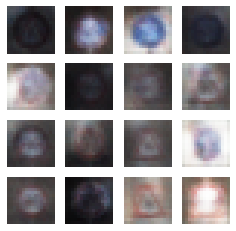

Epoch: 55, Test set ELBO: -392.45123291015625, time elapse for current epoch 15.092629671096802


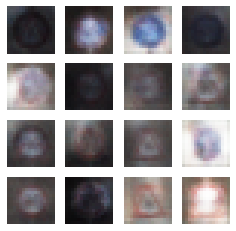

Epoch: 56, Test set ELBO: -392.14288330078125, time elapse for current epoch 16.407655239105225


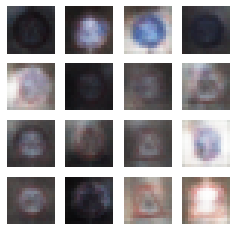

Epoch: 57, Test set ELBO: -392.3615417480469, time elapse for current epoch 15.051285743713379


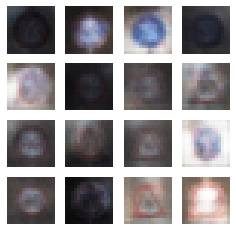

Epoch: 58, Test set ELBO: -392.05926513671875, time elapse for current epoch 15.030518531799316


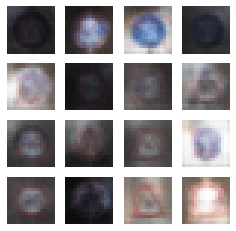

Epoch: 59, Test set ELBO: -392.040771484375, time elapse for current epoch 15.208836317062378


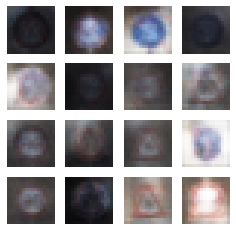

Epoch: 60, Test set ELBO: -391.9859313964844, time elapse for current epoch 15.470829725265503


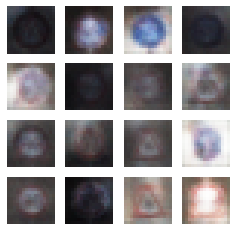

Epoch: 61, Test set ELBO: -391.943115234375, time elapse for current epoch 15.281486749649048


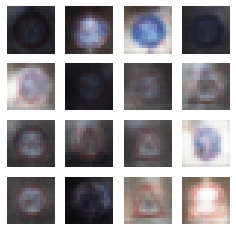

Epoch: 62, Test set ELBO: -391.99560546875, time elapse for current epoch 15.869148015975952


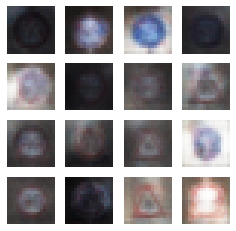

Epoch: 63, Test set ELBO: -391.8005676269531, time elapse for current epoch 15.149285316467285


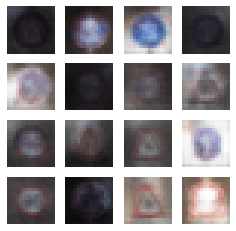

Epoch: 64, Test set ELBO: -391.8518371582031, time elapse for current epoch 15.287491798400879


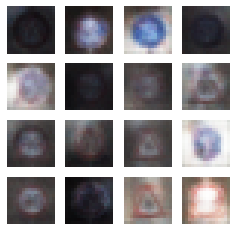

Epoch: 65, Test set ELBO: -391.61029052734375, time elapse for current epoch 15.070791482925415


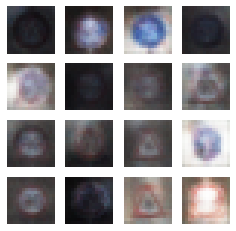

Epoch: 66, Test set ELBO: -391.525634765625, time elapse for current epoch 15.085160970687866


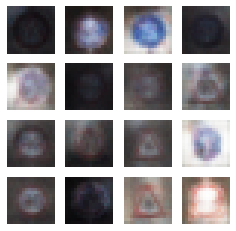

Epoch: 67, Test set ELBO: -391.632080078125, time elapse for current epoch 15.128044128417969


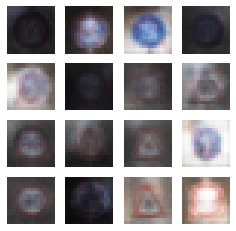

Epoch: 68, Test set ELBO: -391.6024475097656, time elapse for current epoch 16.76889395713806


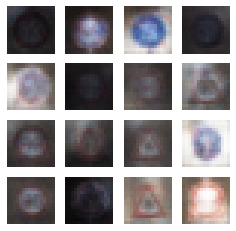

Epoch: 69, Test set ELBO: -391.2170104980469, time elapse for current epoch 15.04774260520935


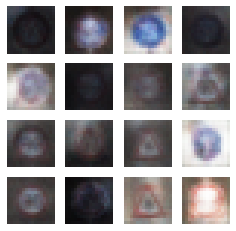

Epoch: 70, Test set ELBO: -391.2319641113281, time elapse for current epoch 15.111948251724243


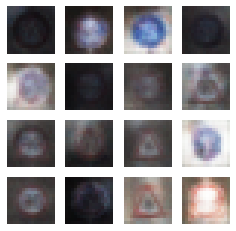

Epoch: 71, Test set ELBO: -391.3258361816406, time elapse for current epoch 15.214332580566406


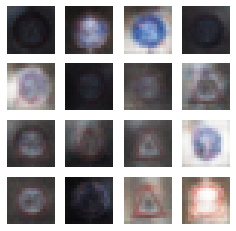

Epoch: 72, Test set ELBO: -391.1522521972656, time elapse for current epoch 15.430616855621338


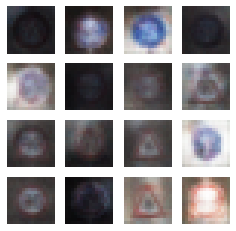

Epoch: 73, Test set ELBO: -391.3193359375, time elapse for current epoch 15.28865098953247


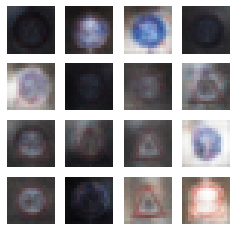

Epoch: 74, Test set ELBO: -391.1225280761719, time elapse for current epoch 15.286073923110962


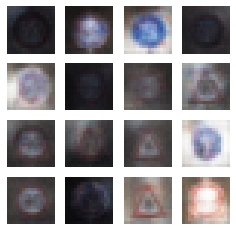

Epoch: 75, Test set ELBO: -391.2101135253906, time elapse for current epoch 15.444870233535767


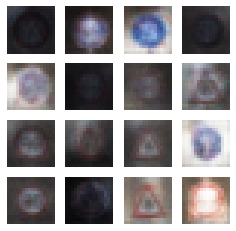

Epoch: 76, Test set ELBO: -391.1068115234375, time elapse for current epoch 15.68815279006958


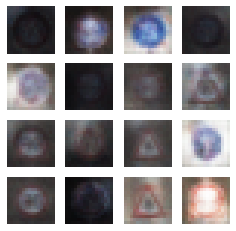

Epoch: 77, Test set ELBO: -390.83843994140625, time elapse for current epoch 15.43190336227417


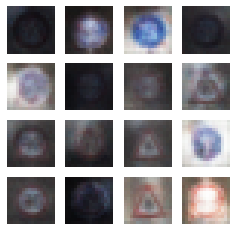

Epoch: 78, Test set ELBO: -390.97430419921875, time elapse for current epoch 15.324939012527466


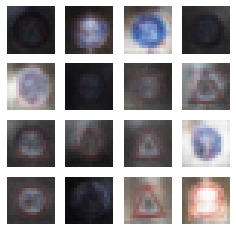

Epoch: 79, Test set ELBO: -390.7723693847656, time elapse for current epoch 15.519692659378052


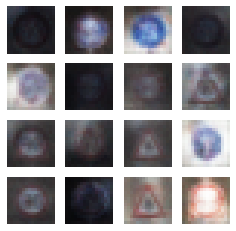

Epoch: 80, Test set ELBO: -390.94818115234375, time elapse for current epoch 15.691455602645874


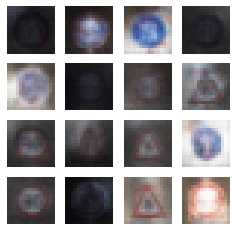

Epoch: 81, Test set ELBO: -390.83819580078125, time elapse for current epoch 15.157477855682373


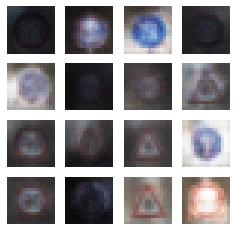

Epoch: 82, Test set ELBO: -390.9500732421875, time elapse for current epoch 15.18839979171753


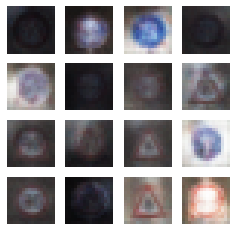

Epoch: 83, Test set ELBO: -390.8653869628906, time elapse for current epoch 15.343483686447144


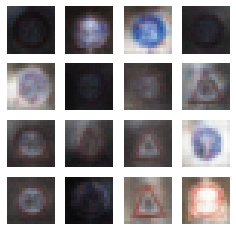

Epoch: 84, Test set ELBO: -390.7456970214844, time elapse for current epoch 15.36949372291565


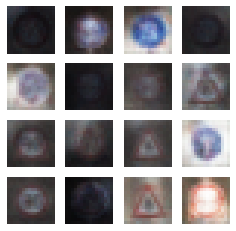

Epoch: 85, Test set ELBO: -390.5616149902344, time elapse for current epoch 15.357780694961548


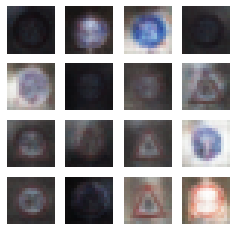

Epoch: 86, Test set ELBO: -390.6910400390625, time elapse for current epoch 15.344198942184448


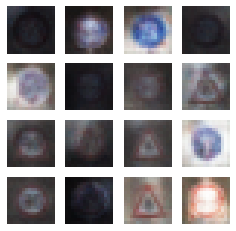

Epoch: 87, Test set ELBO: -390.4110107421875, time elapse for current epoch 15.166080236434937


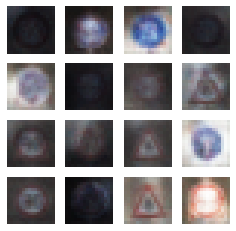

Epoch: 88, Test set ELBO: -390.46002197265625, time elapse for current epoch 15.663522243499756


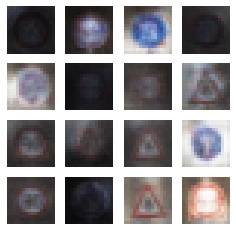

Epoch: 89, Test set ELBO: -390.46075439453125, time elapse for current epoch 15.215483903884888


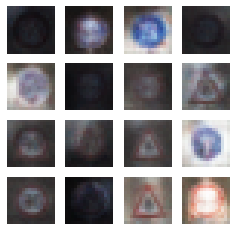

Epoch: 90, Test set ELBO: -390.4544982910156, time elapse for current epoch 15.156283378601074


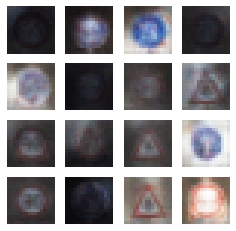

Epoch: 91, Test set ELBO: -390.4714660644531, time elapse for current epoch 16.9438259601593


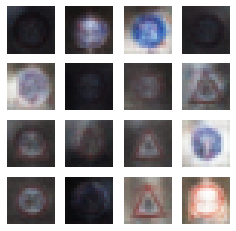

Epoch: 92, Test set ELBO: -390.5002746582031, time elapse for current epoch 16.38987159729004


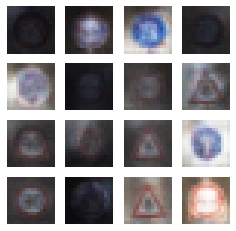

Epoch: 93, Test set ELBO: -390.1034851074219, time elapse for current epoch 15.949325323104858


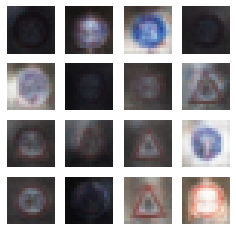

Epoch: 94, Test set ELBO: -390.2720031738281, time elapse for current epoch 15.155259370803833


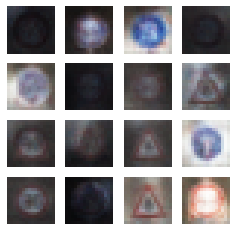

Epoch: 95, Test set ELBO: -390.20458984375, time elapse for current epoch 15.62336778640747


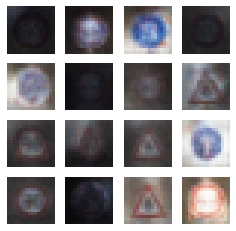

Epoch: 96, Test set ELBO: -390.224853515625, time elapse for current epoch 16.318528175354004


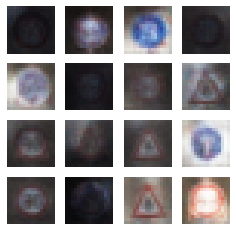

Epoch: 97, Test set ELBO: -390.1108093261719, time elapse for current epoch 15.47476577758789


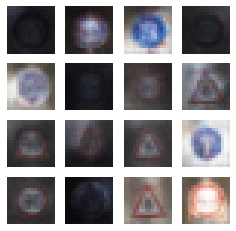

Epoch: 98, Test set ELBO: -390.2036437988281, time elapse for current epoch 15.42757248878479


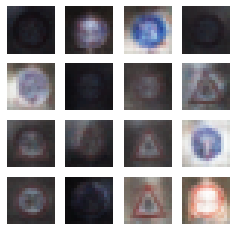

Epoch: 99, Test set ELBO: -390.58306884765625, time elapse for current epoch 15.30522346496582


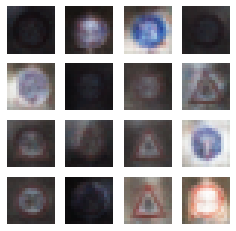

Epoch: 100, Test set ELBO: -390.1753845214844, time elapse for current epoch 19.457208395004272


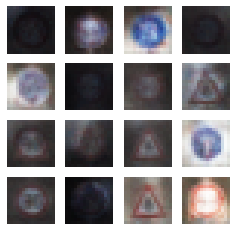

In [13]:
# tf.config.experimental_run_functions_eagerly(True)
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
      
    elbo = -loss.result()
    
    # display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                  end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

### Display an image using the epoch number

In [0]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

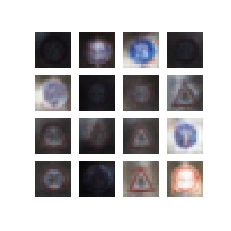

In [16]:
plt.imshow(display_image(epochs))
plt.axis('off')# Display images

### Generate a GIF of all the saved images.

In [0]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)